In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
Root = "/content/drive/MyDrive/ColabNotebooks/RAVDESS"
os.chdir(Root)

# SPEECH RECOGNITION

In [ ]:
!pip install git+https://github.com/Uberi/speech_recognition.git

  Cloning https://github.com/Uberi/speech_recognition.git to /tmp/pip-req-build-2ajfj798
  Running command git clone --filter=blob:none --quiet https://github.com/Uberi/speech_recognition.git /tmp/pip-req-build-2ajfj798
  Resolved https://github.com/Uberi/speech_recognition.git to commit 8b07762f80dfec2d34fb4c40b8eddbb7ec503521
  Preparing metadata (setup.py) ... done
  Created wheel for SpeechRecognition: filename=SpeechRecognition-3.10.0-py2.py3-none-any.whl size=32838801 sha256=c94add653c8465cc18087052d571e3c91b8ee33123712bdfb267ac31514a706d
  Stored in directory: /tmp/pip-ephem-wheel-cache-c_5wf_z0/wheels/96/f7/72/9fba44bd2f03ed8f009f05ef2d56614034ea3efae8fbdec329
Successfully built SpeechRecognition


In [ ]:
audio_files = glob.glob("/content/drive/MyDrive/ColabNotebooks/RAVDESS/Actor_01*/*.wav")

In [ ]:
import speech_recognition as sr

def speech_to_text(audio_file_path):
    recognizer = sr.Recognizer()

    # Load the audio file
    with sr.AudioFile(audio_file_path) as source:
        audio = recognizer.record(source)  # Read the entire audio file

    try:
        # Recognize speech using Google Web Speech API
        text = recognizer.recognize_google(audio)
        return text
    except sr.RequestError as e:
        print("Could not request results from Google Web Speech API; {0}".format(e))
        return None
    except sr.UnknownValueError:
        print("Google Web Speech API could not understand audio")
        return None

# Process each audio file and transcribe speech
for audio_file_path in audio_files:
    print(f"Transcribing speech from {audio_file_path}:")
    transcription = speech_to_text(audio_file_path)

    if transcription:
        print("Transcription:", transcription)
    else:
        print("Speech recognition failed or no speech detected.")


Transcribing speech from /content/drive/MyDrive/ColabNotebooks/RAVDESS/Actor_01/03-01-01-01-01-01-01.wav:
Transcription: kids are talking by the door
Transcribing speech from /content/drive/MyDrive/ColabNotebooks/RAVDESS/Actor_01/03-01-01-01-02-01-01.wav:
Transcription: dogs are sitting by the door
Transcribing speech from /content/drive/MyDrive/ColabNotebooks/RAVDESS/Actor_01/03-01-01-01-02-02-01.wav:
Transcription: dogs are sitting by the door
Transcribing speech from /content/drive/MyDrive/ColabNotebooks/RAVDESS/Actor_01/03-01-02-01-01-02-01.wav:
Transcription: kids are talking by the door
Transcribing speech from /content/drive/MyDrive/ColabNotebooks/RAVDESS/Actor_01/03-01-01-01-01-02-01.wav:
Transcription: kids are talking by the door
Transcribing speech from /content/drive/MyDrive/ColabNotebooks/RAVDESS/Actor_01/03-01-02-01-02-01-01.wav:
Transcription: dogs are sitting by the door
Transcribing speech from /content/drive/MyDrive/ColabNotebooks/RAVDESS/Actor_01/03-01-02-01-01-01-01

# MODEL TRAINING, TESTING AND PREDICTION

In [ ]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [ ]:
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype='float32')
        sample_rate = sound_file.samplerate
        if chroma:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr = sample_rate, n_mfcc = 40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr = sample_rate).T, axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel))
        pass
    return result

In [ ]:
emotions = {
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised'
}

observed_emotions = ['calm', 'happy', 'fearful', 'disgust']

In [ ]:
import os
def load_data(num_files=None,test_size=0.2, desired_feature_dim=(180,)):
    x,y = [],[]
    num_processed_files = 0
    for file in glob.glob("/content/drive/MyDrive/ColabNotebooks/RAVDESS/Actor_*/*.wav", recursive=True):
        if num_files is not None and num_processed_files >= num_files:
            break
        file_name = os.path.basename(file)
        emotion = emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature = extract_feature(file, mfcc=True, chroma = True, mel = True)
        if feature.shape != desired_feature_dim:
            if feature.shape[0] < desired_feature_dim[0]:
              print('Entered here')
              feature = np.pad(feature, ((0, desired_feature_dim[0] - feature.shape[0]),), 'constant')
            else:
                feature = feature[:desired_feature_dim[0]]
        x.append(feature)
        y.append(emotion)
        num_processed_files += 1
    x = np.vstack(x)
    y = np.array(y)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=9)
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)

    return x_train, x_test, y_train, y_test
desired_feature_dim = (180,)
num_files_to_process = 100


In [ ]:
x_train, x_test, y_train, y_test = load_data(num_files=num_files_to_process,test_size=0.25, desired_feature_dim=desired_feature_dim)

In [ ]:
x_train

array([[-7.09391663e+02,  8.60269470e+01,  1.51981688e+01, ...,
         2.50167016e-08,  8.32359426e-09,  7.76454367e-09],
       [-4.60460144e+02,  4.93337326e+01, -8.92392445e+00, ...,
         2.01565417e-05,  2.65355357e-06,  1.26117534e-08],
       [-4.18499878e+02,  3.95912743e+01, -2.55921078e+01, ...,
         2.82996953e-05,  2.61020000e-06,  1.50892649e-08],
       ...,
       [-5.58987000e+02,  4.96863327e+01,  2.84183407e+00, ...,
         1.63384868e-06,  1.44974493e-07,  8.96650665e-09],
       [-5.67402344e+02,  5.57089348e+01,  4.05570841e+00, ...,
         8.59144677e-07,  8.19519315e-08,  8.97730779e-09],
       [-5.78706177e+02,  5.09078293e+01,  8.71209681e-01, ...,
         3.07784239e-06,  3.75981926e-07,  8.20312263e-09]])

In [ ]:
y_train

array(['calm', 'fearful', 'fearful', 'fearful', 'disgust', 'calm',
       'happy', 'fearful', 'disgust', 'calm', 'calm', 'fearful', 'happy',
       'happy', 'happy', 'happy', 'fearful', 'disgust', 'happy', 'happy',
       'fearful', 'happy', 'calm', 'calm', 'fearful', 'calm', 'fearful',
       'calm', 'happy', 'happy', 'disgust', 'happy', 'disgust', 'happy',
       'disgust', 'calm', 'fearful', 'calm', 'disgust', 'disgust',
       'disgust', 'calm', 'calm', 'fearful', 'disgust', 'disgust', 'calm',
       'fearful', 'disgust', 'happy', 'calm', 'fearful', 'happy', 'calm',
       'happy', 'happy', 'fearful', 'disgust', 'calm', 'fearful', 'calm',
       'happy', 'calm', 'fearful', 'happy', 'happy', 'calm', 'disgust',
       'fearful', 'calm', 'calm', 'disgust', 'disgust', 'disgust',
       'disgust'], dtype='<U7')

In [ ]:
print((x_train.shape[0], x_test.shape[0]))

(75, 25)


In [ ]:
print(f'Features Extracted: {x_train.shape[1]}')

Features Extracted: 180


In [ ]:
model = MLPClassifier(alpha=0.01, batch_size = 256, epsilon = 1e-08, hidden_layer_sizes = (300,), learning_rate = 'adaptive', max_iter  = 500)

In [ ]:
model.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [ ]:
y_pred  = model.predict(x_test)
y_pred

array(['happy', 'calm', 'calm', 'calm', 'calm', 'calm', 'fearful',
       'fearful', 'disgust', 'disgust', 'happy', 'disgust', 'calm',
       'disgust', 'disgust', 'fearful', 'happy', 'happy', 'disgust',
       'disgust', 'fearful', 'fearful', 'disgust', 'happy', 'calm'],
      dtype='<U7')

In [ ]:
accuracy = accuracy_score(y_true = y_test, y_pred = y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 92.00%


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
f1_score(y_test, y_pred, average=None)

array([1.        , 0.85714286, 0.83333333, 1.        ])

In [ ]:
import pandas as pd
df = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df.head(20)

,Actual,Predicted
0,happy,happy
1,calm,calm
2,calm,calm
3,calm,calm
4,calm,calm
5,calm,calm
6,fearful,fearful
7,fearful,fearful
8,fearful,disgust
9,fearful,disgust


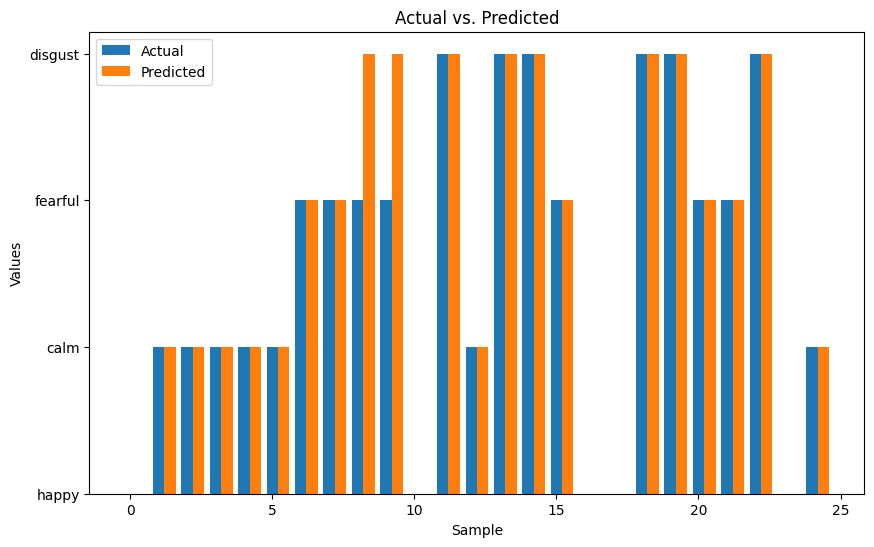

In [ ]:
plt.figure(figsize=(10, 6))
bar_width = 0.4  # Adjust this value to control the distance between bars

plt.bar(range(len(y_test)), y_test, width=bar_width, label='Actual')
plt.bar([i + bar_width for i in range(len(y_pred))], y_pred, width=bar_width, label='Predicted')

plt.xlabel('Sample')
plt.ylabel('Values')
plt.title('Actual vs. Predicted')
plt.legend()
plt.show()

In [ ]:
import pickle
with open('modelForPrediction1.sav', 'wb') as f:
  pickle.dump(model,f)

In [ ]:
filename = 'modelForPrediction1.sav'
loaded_model = pickle.load(open(filename, 'rb'))
feature = extract_feature("/content/drive/MyDrive/ColabNotebooks/RAVDESS/Actor_01/03-01-01-01-01-01-01.wav", mfcc=True, chroma = True, mel=True)
feature = feature.reshape(1,-1)
prediction = loaded_model.predict(feature)
prediction

array(['disgust'], dtype='<U7')

# DATA VISUALIZATION AND EXPLORATION

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle


In [ ]:
audio_files = glob.glob("/content/drive/MyDrive/ColabNotebooks/RAVDESS/*/*.wav")

In [ ]:
import IPython.display as ipd
ipd.Audio(audio_files[0])

In [ ]:
y, sr = librosa.load(audio_files[0])
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y: [-3.1755146e-08  3.1958518e-08 -3.0679264e-08  2.8371874e-08
 -2.4933929e-08  2.0277851e-08 -1.4337583e-08  7.0691204e-09
  1.5432811e-09 -1.1484202e-08]
shape y: (86817,)
sr: 22050


In [ ]:
pd.Series(y)

0       -3.175515e-08
1        3.195852e-08
2       -3.067926e-08
3        2.837187e-08
4       -2.493393e-08
             ...     
86812    1.046954e-06
86813   -8.623251e-07
86814    7.137410e-07
86815   -5.888238e-07
86816    0.000000e+00
Length: 86817, dtype: float32

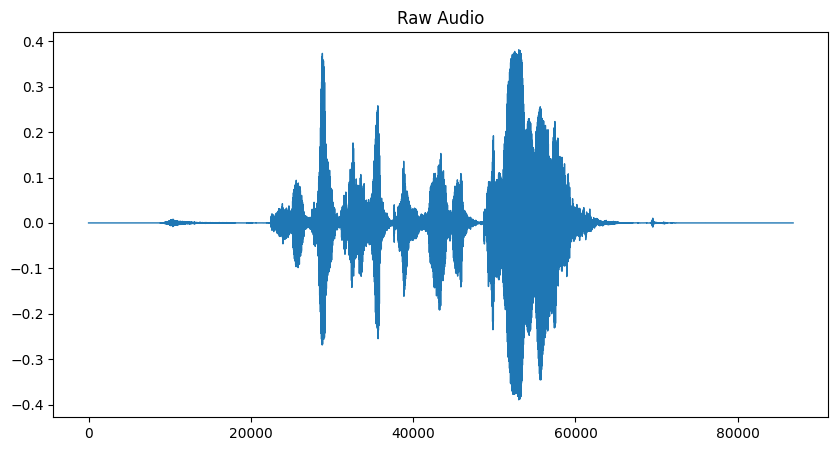

In [ ]:
pd.Series(y).plot(figsize=(10,5), lw=1, title='Raw Audio')
plt.show()

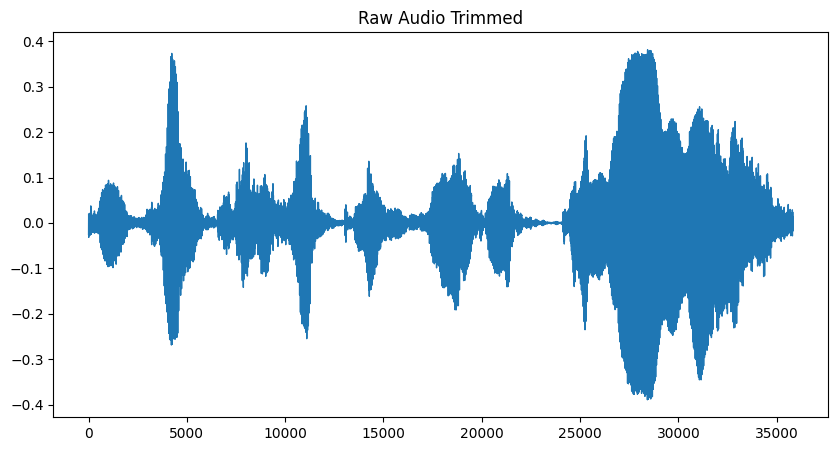

In [ ]:
y_trimmed, _ = librosa.effects.trim(y, top_db = 20)
pd.Series(y_trimmed).plot(figsize=(10,5), lw=1, title='Raw Audio Trimmed')
plt.show()

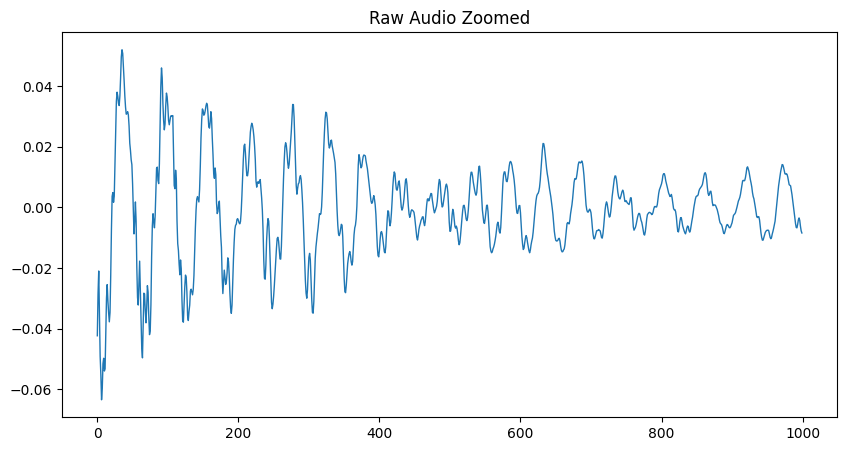

In [ ]:
pd.Series(y[30000:31000]).plot(figsize=(10,5), lw=1, title='Raw Audio Zoomed')
plt.show()

In [ ]:
## Spectogram

D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref = np.max)
S_db.shape

(1025, 170)

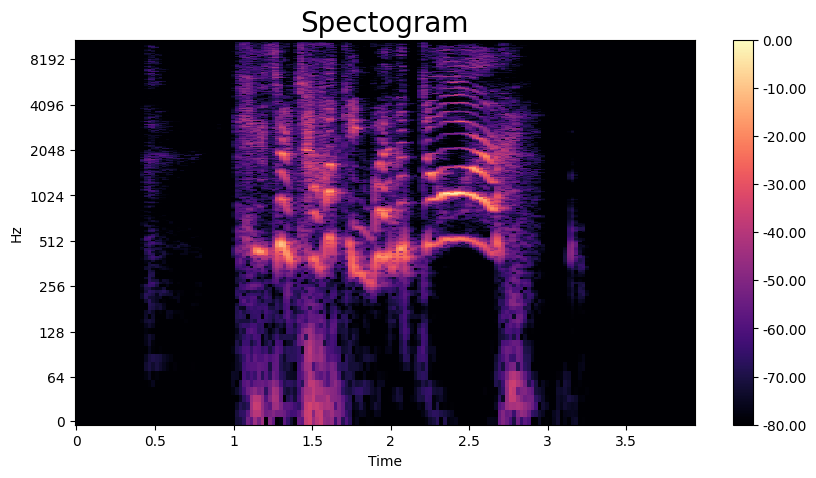

In [ ]:
## Plot the transformed audio data
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(S_db, x_axis='time', y_axis = 'log', ax=ax)
ax.set_title('Spectogram', fontsize = 20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

In [ ]:
## Mel(Melodic) Spectrogram

S= librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128*2)
S_db_mel = librosa.amplitude_to_db(S, ref = np.max)

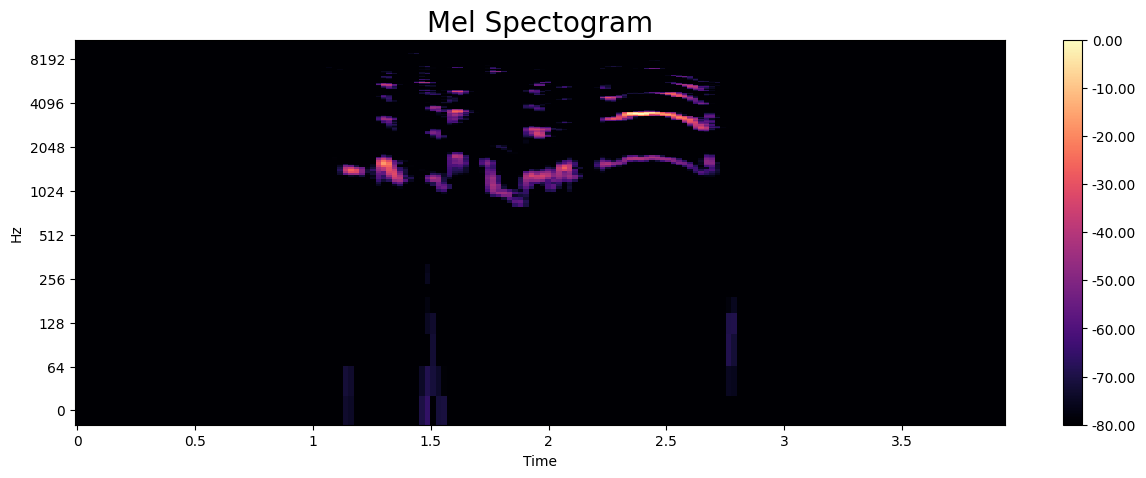

In [ ]:
# PLot the mel spectrogram
fig, ax = plt.subplots(figsize=(15,5))

img = librosa.display.specshow(S_db_mel,  x_axis='time', y_axis = 'log', ax=ax)
ax.set_title('Mel Spectogram', fontsize = 20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

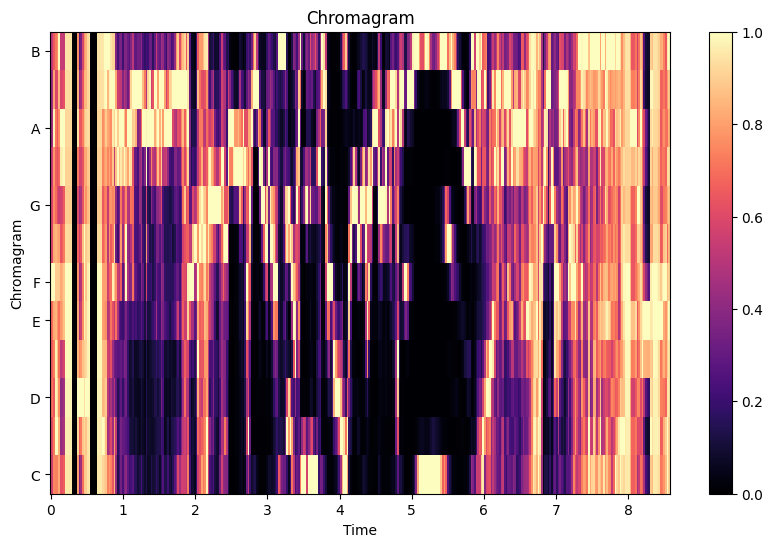

In [ ]:
audio_fil= glob.glob("/content/drive/MyDrive/ColabNotebooks/RAVDESS/*/*.wav")
def visualize_chromagram(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    chromagram = librosa.feature.chroma_stft(y=audio, sr=sr)

    plt.figure(figsize=(10, 6))
    librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma')
    plt.colorbar()
    plt.title('Chromagram')
    plt.xlabel('Time')
    plt.ylabel('Chromagram')
    plt.show()

# Visualize chromagram for the first audio file in the dataset
visualize_chromagram(audio_fil[0])

In [ ]:
audio_files1 = glob.glob("/content/drive/MyDrive/ColabNotebooks/RAVDESS_Noisy*/*.wav")
import IPython.display as ipd
ipd.Audio(audio_files1[0])

# NOISE INJECTION

In [ ]:
pip install soundfile

In [ ]:
import os
import librosa
import numpy as np
import soundfile as sf

def add_noise(audio, noise_level=0.05):
    noise = np.random.normal(0, noise_level, len(audio))
    noisy_audio = audio + noise
    return noisy_audio

input_dir = "/content/drive/MyDrive/ColabNotebooks/RAVDESS"
output_dir = "/content/drive/MyDrive/ColabNotebooks/RAVDESS_Noisy"

os.makedirs(output_dir, exist_ok=True)

for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.endswith(".wav"):
            audio_file_path = os.path.join(root, file)
            y, sr = librosa.load(audio_file_path, sr=None)
            noisy_audio = add_noise(y, noise_level=0.001)
            output_file_path = os.path.join(output_dir, file)
            sf.write(output_file_path, noisy_audio, sr)


In [ ]:
audio_files = glob.glob("/content/drive/MyDrive/ColabNotebooks/RAVDESS_Noisy*/*.wav")
import IPython.display as ipd
ipd.Audio(audio_files[0])


# STRETCHING

In [ ]:
import os
import librosa
import soundfile as sf

def stretch_audio(audio, stretch_factor=1.2):
    stretched_audio = librosa.effects.time_stretch(audio, rate=stretch_factor)
    return stretched_audio

input_dir = "/content/drive/MyDrive/ColabNotebooks/RAVDESS_Noisy"
output_dir = "/content/drive/MyDrive/ColabNotebooks/RAVDESS_Stretched"

os.makedirs(output_dir, exist_ok=True)

for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.endswith(".wav"):
            noisy_audio_file_path = os.path.join(root, file)
            y, sr = librosa.load(noisy_audio_file_path, sr=None)
            stretch_factor = 1.2
            stretched_audio = stretch_audio(y, stretch_factor)
            output_file_path = os.path.join(output_dir, file)
            sf.write(output_file_path, stretched_audio, sr)


In [ ]:
audio_files = glob.glob("/content/drive/MyDrive/ColabNotebooks/RAVDESS_Stretched*/*.wav")
import IPython.display as ipd
ipd.Audio(audio_files[0])

# SHIFTING

In [ ]:
import os
import librosa
import soundfile as sf

def shift_pitch(audio, pitch_steps=2):
    shifted_audio = librosa.effects.pitch_shift(audio, sr=22050, n_steps=pitch_steps)
    return shifted_audio

input_dir = "/content/drive/MyDrive/ColabNotebooks/RAVDESS_Stretched"
output_dir = "/content/drive/MyDrive/ColabNotebooks/RAVDESS_Noisy_Shifted"

os.makedirs(output_dir, exist_ok=True)

for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.endswith(".wav"):
            noisy_audio_file_path = os.path.join(root, file)
            y, sr = librosa.load(noisy_audio_file_path, sr=None)
            shifted_audio = shift_pitch(y, pitch_steps)
            output_file_path = os.path.join(output_dir, file)
            sf.write(output_file_path, shifted_audio, sr)

In [ ]:
audio_files = glob.glob("/content/drive/MyDrive/ColabNotebooks/RAVDESS_Shifted*/*.wav")
import IPython.display as ipd
ipd.Audio(audio_files[0])

# Pitch

In [ ]:
import os
import librosa
import soundfile as sf

def change_pitch(audio, pitch_shift_factor=1.0):
    target_pitch = pitch_shift_factor * 12
    pitched_audio = librosa.effects.pitch_shift(audio, sr=22050, n_steps=target_pitch)
    return pitched_audio

input_dir = "/content/drive/MyDrive/ColabNotebooks/RAVDESS_Shifted"
output_dir = "/content/drive/MyDrive/ColabNotebooks/RAVDESS_PitchChanged"

os.makedirs(output_dir, exist_ok=True)

for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.endswith(".wav"):
            noisy_audio_file_path = os.path.join(root, file)
            y, sr = librosa.load(noisy_audio_file_path, sr=None)
            pitch_shift_factor = 1.5
            pitched_audio = change_pitch(y, pitch_shift_factor)
            output_file_path = os.path.join(output_dir, file)
            sf.write(output_file_path, pitched_audio, sr)


In [ ]:
audio_files = glob.glob("/content/drive/MyDrive/ColabNotebooks/RAVDESS_PitchChanged*/*.wav")
import IPython.display as ipd
ipd.Audio(audio_files[0])

# FEATURE EXTRACTION

In [ ]:
file_name = "/content/drive/MyDrive/ColabNotebooks/RAVDESS/Actor_24/03-01-01-01-01-01-24.wav"  # Replace with the actual file path

# Extract features from the audio file
features = extract_feature(file_name, mfcc=True, chroma=True, mel=True)

# Check if features were successfully extracted
if features is not None:
    print("Extracted Features:")
    print(features)
else:
    print("Failed to extract features from the audio.")

Extracted Features:
[-7.08187744e+02  6.02639542e+01 -3.81218910e+00  4.61566925e+00
 -4.94149590e+00 -6.03771508e-01 -9.85057068e+00 -3.95951128e+00
 -1.08225670e+01 -8.12163639e+00 -4.76909924e+00 -6.38338757e+00
 -6.26873446e+00 -5.18147516e+00 -3.02242446e+00 -5.24778795e+00
 -5.77325249e+00 -1.44164121e+00 -5.87681627e+00 -5.09334803e+00
 -3.48406887e+00 -5.28111887e+00 -4.45835781e+00 -4.92420959e+00
 -4.17169380e+00 -4.42188549e+00 -4.67947340e+00 -3.37072468e+00
 -3.53976965e+00 -3.05512691e+00 -1.67332768e+00 -1.13374448e+00
 -3.22819850e-03  2.98774112e-02  4.59981024e-01  1.43007720e+00
  2.09024429e+00  3.52165914e+00  4.12172270e+00  5.74772501e+00
  5.09498417e-01  4.87456709e-01  4.83176440e-01  4.82587934e-01
  4.74420130e-01  4.68577951e-01  5.05407989e-01  5.62192202e-01
  5.91775894e-01  5.90960026e-01  5.59514284e-01  5.46361625e-01
  3.28575254e-07  1.09098096e-06  2.71323779e-06  3.28918577e-06
  3.79888021e-04  9.80969798e-03  2.72392929e-02  2.98111457e-02
  1.0